# Music Auto-tagging

In [1]:
import torch
import torchaudio
import IPython.display as ipd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install --upgrade gdown
!gdown 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
# !wget https://sogang365-my.sharepoint.com/:u:/g/personal/dasaem_jeong_o365_sogang_ac_kr/EdkHWV-qvxBEi-d0Ua73VG4BEp7EZO7HMvrXsWqeJvMJzg?e=GbYylV&download=1

!unzip -q mtat_8000.zip

Downloading...
From (original): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
From (redirected): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6&confirm=t&uuid=3784618d-eeaa-49b0-a231-dac7d3aac1e8
To: /content/mtat_8000.zip
100% 921M/921M [00:15<00:00, 61.3MB/s]


In [3]:
# check dataset
data_dir = Path('MTAT_SMALL')
assert data_dir.exists()

mp3_fns = list(data_dir.rglob('*.mp3'))
len(mp3_fns)

mp3_fn = mp3_fns[0]
y, sr = torchaudio.load(mp3_fn)
print(mp3_fn, sr)
ipd.Audio(y, rate=sr)

MTAT_SMALL/2/claire_fitch-ambiencellist-04-calm_pad-88-117.mp3 16000


In [4]:
df = pd.read_csv('MTAT_SMALL/meta.csv', index_col=[0])
df.columns.values[1:-1]

array(['singer', 'harpsichord', 'sitar', 'heavy', 'foreign', 'no piano',
       'classical', 'female', 'jazz', 'guitar', 'quiet', 'solo', 'folk',
       'ambient', 'new age', 'synth', 'drum', 'bass', 'loud', 'string',
       'opera', 'fast', 'country', 'violin', 'electro', 'trance', 'chant',
       'strange', 'modern', 'hard', 'harp', 'pop', 'female vocal',
       'piano', 'orchestra', 'eastern', 'slow', 'male', 'vocal',
       'no singer', 'india', 'rock', 'dance', 'cello', 'techno', 'flute',
       'beat', 'soft', 'choir', 'baroque'], dtype=object)

In [5]:
str(mp3_fn.relative_to('MTAT_SMALL/'))

'2/claire_fitch-ambiencellist-04-calm_pad-88-117.mp3'

In [6]:
df[df['mp3_path']==str(mp3_fn.relative_to('MTAT_SMALL/'))]

,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
7711,16912,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2/claire_fitch-ambiencellist-04-calm_pad-88-11...


In [7]:
from tqdm.auto import tqdm

class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    elif split=='test': #test
      sub_dir_ids = ['e', 'f', 'g']
    else:
      raise NotImplementedError

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set] # filter label by is_in_set
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
    self.audios = self.load_audio()

  def convert_label_to_tensor(self):
    return torch.tensor(self.labels.values[:, 1:-1].astype('bool'), dtype=torch.float)

  def load_audio(self):
    audios = []
    for idx in tqdm(range(len(self))):
      info = self.labels.iloc[idx]
      mp3_path = self.dir / info['mp3_path']
      audio, sr = torchaudio.load(mp3_path)
      audios.append(audio)
    return audios


  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    # info = self.labels.iloc[idx]
    # mp3_path = self.dir / info['mp3_path']

    # audio, sr = torchaudio.load(mp3_path)
    # assert sr == self.sr
    audio = self.audios[idx]
    label = self.label_tensor[idx]
    return audio, label

train_set = MTATDataset('MTAT_SMALL')

audio, label = train_set[4000]
ipd.display(ipd.Audio(audio, rate=train_set.sr, normalize=False))
print(label)

# convert multi-hot label to readable tag
actviated_tag_idxs = torch.where(label)[0]
train_set.vocab[actviated_tag_idxs]

  0%|          | 0/5000 [00:00<?, ?it/s]

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


array(['singer', 'female', 'modern', 'female vocal', 'piano', 'vocal'],
      dtype=object)

In [8]:
import torch.nn as nn
class AutoTagger(nn.Module):
  def __init__(self, out_size=50):
    super().__init__()
    self.mel = torchaudio.transforms.MelSpectrogram(n_fft=2048, hop_length=1024, n_mels=80)
    self.db = torchaudio.transforms.AmplitudeToDB()
    self.conv_stack = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2), # kernel_size can be in tuple.
        nn.Conv2d(16, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2), # kernel_size can be in tuple.
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2) # kernel_size can be in tuple.
    )
    self.final_pool = nn.AdaptiveMaxPool1d(1) # fix output size, rather than kernel size
    self.proj = nn.Linear(512, out_size) # 512 only works for specific height of input

  def forward(self, x):
    # print(f"Audio shape: {x.shape}")
    x = self.mel(x)
    x = self.db(x) / 80
    # print(f"Mel shape: {x.shape}")
    x = self.conv_stack(x)
    # print(f"Conv out shape: {x.shape}")

    x = x.flatten(-3, -2) # N x C x H x W -> N x (CxH) x W
    # print(f"flatten shape: {x.shape}")

    # x = torch.max(x, dim=-1)[0] # take max pool over time axis. and use [0] for getting value. [1] is index
    x = self.final_pool(x).squeeze(-1)
    x = self.proj(x)


    return x.sigmoid()

model = AutoTagger()
out = model(audio)
out.shape

torch.Size([50])

In [11]:
cnn_layer = nn.Conv2d(in_channels=1,
                      out_channels=5,
                      kernel_size=3,
                      stride=2, # stride can replace max pool
                      padding=1,
                      dilation=1)

print(audio.shape)
# cnn layer expects input to be N x C x H x W (or C x H x W)
unsq_spec = audio.unsqueeze(0)
print(unsq_spec.shape)
cnn_out = cnn_layer(unsq_spec)
print(f"cnn_out.shape is {cnn_out.shape}")

torch.Size([1, 465984])
torch.Size([1, 1, 465984])
cnn_out.shape is torch.Size([5, 1, 232992])


In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

batch = next(iter(train_loader))
audio, label = batch

out = model(audio)
out.shape

torch.Size([32, 50])

In [13]:
prob = torch.sigmoid(out)
prob

tensor([[0.6219, 0.6281, 0.6238,  ..., 0.6229, 0.6201, 0.6244],
        [0.6216, 0.6283, 0.6243,  ..., 0.6227, 0.6203, 0.6245],
        [0.6214, 0.6281, 0.6241,  ..., 0.6229, 0.6204, 0.6243],
        ...,
        [0.6217, 0.6283, 0.6241,  ..., 0.6231, 0.6203, 0.6243],
        [0.6217, 0.6280, 0.6243,  ..., 0.6228, 0.6205, 0.6245],
        [0.6218, 0.6285, 0.6235,  ..., 0.6240, 0.6196, 0.6237]],
       grad_fn=<SigmoidBackward0>)

In [14]:
def get_binary_cross_entropy(pred, target):
  loss = -(target * torch.log(pred + 1e-8) + (1-target) * torch.log(1-pred+1e-8))
  return loss.mean()

# - (y log(y_hat) +  (1-y)log(1-y_hat) )
loss = get_binary_cross_entropy(prob.cpu(), label)
loss

tensor(0.9369, grad_fn=<MeanBackward0>)

In [15]:
print(prob.shape, label.shape)

torch.Size([32, 50]) torch.Size([32, 50])


In [16]:
DEV = 'cuda'

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
model = AutoTagger()
optimizer = torch.optim.Adam(model.parameters())

loss_record = []
n_epoch = 5
model = model.to(DEV)


for epoch in range(n_epoch):
  for batch in tqdm(train_loader, leave=False):
    audio, label = batch
    prob = model(audio.to(DEV))
    loss = get_binary_cross_entropy(prob, label.to(DEV))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

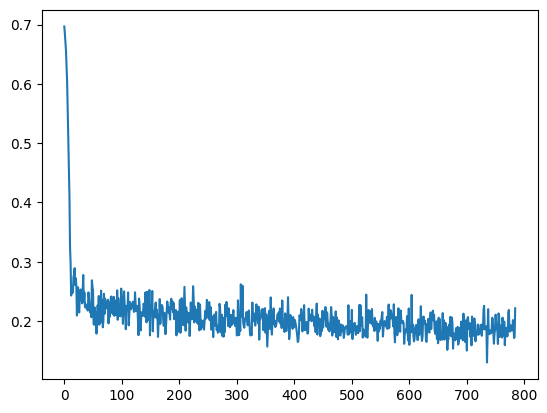

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_record)

In [18]:
valid_set = MTATDataset('MTAT_SMALL', split='valid', num_max_data=100)


  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
torch.set_printoptions(sci_mode=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=100, shuffle=False)

batch = next(iter(valid_loader))
model = model.cpu()
audio, label = batch
prob = model(audio)


In [52]:
threshold = 0.5
thresholded_pred = (prob > threshold).float()
is_correct = thresholded_pred == label
num_correct_guess = is_correct.sum()
num_total_guess = prob.numel()

accuracy = num_correct_guess / num_total_guess
accuracy

tensor(0.9426)

In [53]:
null_guess = torch.zeros_like(prob)
(null_guess == label).sum() / num_total_guess

tensor(0.9388)

In [54]:
label.sum()

tensor(306.)

In [55]:
threshold = 0.3
thresholded_pred = (prob > threshold).float()

# precision: true_positive / (total positive prediction)
total_pos_pred = thresholded_pred.sum()
true_positive = (thresholded_pred * label).sum()
precision = true_positive / total_pos_pred
print(precision, true_positive, total_pos_pred)


tensor(0.4571) tensor(112.) tensor(245.)


In [56]:
# recall: true positive / total existing positive sample
true_positive = (thresholded_pred * label).sum()
num_pos_sample = label.sum()
recall = true_positive / num_pos_sample
recall

tensor(0.3660)

In [59]:
# ROC-AUC

# compute true positive ratio
# compute false positive ratio

def get_tpr_fpr(pred, target, threshold):
  thresholded_pred = pred > threshold

  true_positive = (thresholded_pred * (target==1)).sum()
  true_negative = (~thresholded_pred * (target ==0)).sum()
  false_positive = (thresholded_pred * (target ==0)).sum()
  false_negative = (~thresholded_pred * (target ==1)).sum()


  assert true_positive + false_negative == target.sum()
  assert true_negative + false_positive == (1-target).sum()
  tpr = true_positive / (true_positive + false_negative)
  fpr = false_positive / (true_negative + false_positive)

  tpr = true_positive / target.sum()
  fpr = false_positive / 1-target.sum()

  return tpr.item(), fpr.item()

thresholded_pred = prob > threshold
target = label

get_tpr_fpr(prob, label, 0.1)

(0.7124183177947998, 614.0)

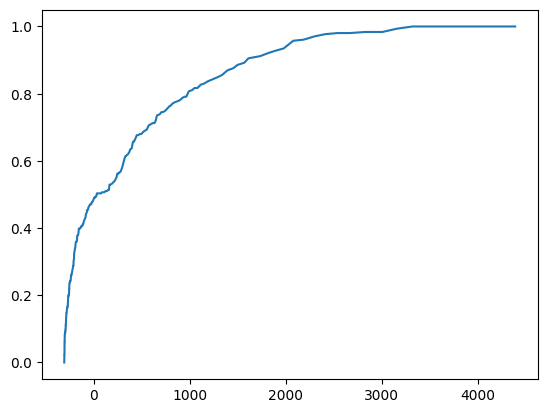

In [60]:
# get roc plot

# threshold 1 - 0
num_grid = 100
tprs = []
fprs = []

for th in reversed(torch.linspace(0,1,500)):
  tpr, fpr = get_tpr_fpr(prob, label, th)
  tprs.append(tpr)
  fprs.append(fpr)

plt.plot(fprs, tprs)


In [86]:
dummy_threshold = torch.rand(50)*0.3
dummy_threshold

tensor([0.1272, 0.1376, 0.0543, 0.1047, 0.0981, 0.0355, 0.2353, 0.2425, 0.0281,
        0.2820, 0.2329, 0.0325, 0.2172, 0.0163, 0.0695, 0.0418, 0.2201, 0.0037,
        0.2609, 0.1007, 0.2298, 0.1033, 0.0516, 0.2483, 0.0390, 0.2606, 0.0564,
        0.2629, 0.2858, 0.0893, 0.2580, 0.2427, 0.0108, 0.2777, 0.1340, 0.1028,
        0.2377, 0.0816, 0.0760, 0.2870, 0.0443, 0.1601, 0.2027, 0.2072, 0.0282,
        0.1969, 0.1173, 0.2474, 0.0448, 0.0757])

In [88]:
# Make inference on Audio
audio, label = valid_set[70]
threshold = 0.13
pred = model(audio)
thresholded_pred = pred > dummy_threshold
# find index of where pred is True
pred_tag_ids = torch.where(thresholded_pred)[0]
valid_set.vocab[pred_tag_ids]
print(valid_set.vocab[pred_tag_ids])
ipd.Audio(audio*0.1, rate=valid_set.sr, normalize=False)

['sitar' 'jazz' 'ambient' 'new age' 'synth' 'bass' 'electro'
 'female vocal' 'vocal' 'india' 'techno']
